# Transfer-Learning: 101 Classes
There is a paper called ["Food-101 - Mining Discriminative Components with Random Forest"](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf), whcih describes image-classification with 1010 classes of food.  
That paper and that idea is the launching pad of this notebook.  

That paper dsicusses how the average accuracy in the model developed there is `50.76%`.  
This notebook is going to try to surpass that accuracy score.  

[Here's another notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb) to check out about dealing with the images from the food101 dataset.


## Notebook goals
Build a model that surpasses the accuracy score found in the paper above:
- use the food101 dataset (can be found [here](https://www.kaggle.com/datasets/dansbecker/food-101))
- Experiment with building "feature-extraction" transfer-learning models
- Fine-Tune a feature-extraction model
- Evaluate The performance of the model
- Save the trained model

## Prep
### Imports

In [31]:
import tensorflow as tf

cifar = tf.keras.datasets.cifar100
(x_train, y_train), (x_test, y_test) = cifar.load_data()
model = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_shape=(32, 32, 3),
    classes=100,)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
model.fit(x_train, y_train, epochs=5, batch_size=64)

169001437/169001437 [==============================] - 70s 0us/step
Epoch 1/5
782/782 [==============================] - 243s 284ms/step - loss: 4.6066 - accuracy: 0.0848
Epoch 2/5
782/782 [==============================] - 206s 264ms/step - loss: 4.3174 - accuracy: 0.1010
Epoch 3/5
782/782 [==============================] - 205s 262ms/step - loss: 3.7268 - accuracy: 0.1642
Epoch 4/5
782/782 [==============================] - 203s 260ms/step - loss: 3.4103 - accuracy: 0.2140
Epoch 5/5
782/782 [==============================] - 205s 262ms/step - loss: 3.3513 - accuracy: 0.2261


In [30]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [32]:
import gc
gc.collect()

680

### Helpers
Get some helper functions

In [33]:
# !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

### Get The Data
Getting `10%` of the data to start experimenting with modeling:

In [3]:
# Download data from Google Storage (already preformatted)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 

In [4]:
# unzip_data("101_food_classes_10_percent.zip")

In [5]:
# to get a brief "inspection" of the data
# walk_through_dir("101_food_classes_10_percent")

### Build Train & Test Vars

In [34]:
imagesDirPath = "101_food_classes_10_percent/"
trainDirPath = imagesDirPath + 'train/'
testDirPath = imagesDirPath + 'test/'
print(f'TRAIN: {trainDirPath} \n TEST: {testDirPath}')

TRAIN: 101_food_classes_10_percent/train/ 
 TEST: 101_food_classes_10_percent/test/


### Convert Images & Labels Into tensorflow datasets

In [27]:
OUTPUT_IMG_SIZE = (224,224)

trainingData10P = tf.keras.preprocessing.image_dataset_from_directory(trainDirPath,
                                                                                label_mode="categorical",
                                                                                image_size=OUTPUT_IMG_SIZE)
                                                                                
testingData10p = tf.keras.preprocessing.image_dataset_from_directory(testDirPath,
                                                                label_mode="categorical",
                                                                image_size=OUTPUT_IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


### Build A Checkpoint Callback

In [28]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

### Build Data-Augmenter

In [29]:
dataAugLayer = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## Model I
### Base Model: EfficientNetB0

In [10]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

In [11]:
howManyClasses = len(testingData10p.class_names)
howManyClasses

101

### Build

In [12]:
m0Inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
m0Applied = dataAugLayer(m0Inputs) # augment images (only happens during training)
m0Applied = base_model(m0Applied, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
m0Applied = layers.GlobalAveragePooling2D(name="global_average_pooling")(m0Applied) # pool the outputs of the base model
m0Outputs = layers.Dense(howManyClasses, activation="softmax", name="output_layer")(m0Applied) # same number of outputs as classes
m0 = tf.keras.Model(m0Inputs, m0Outputs)

In [13]:
m0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

### Compile & Fit

In [14]:
m0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

In [15]:
howManyValidationSteps = int(0.15 * len(testingData10p))
howManyValidationSteps

118

In [16]:
m0History = m0.fit(trainingData10P,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=testingData10p,
                                           validation_steps=int(0.15 * len(testingData10p)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 430s 2s/step - loss: 3.3797 - accuracy: 0.2776 - val_loss: 2.4227 - val_accuracy: 0.4841
Epoch 2/5
237/237 [==============================] - 322s 1s/step - loss: 2.1932 - accuracy: 0.4983 - val_loss: 1.9924 - val_accuracy: 0.5328
Epoch 3/5
237/237 [==============================] - 237s 999ms/step - loss: 1.8072 - accuracy: 0.5691 - val_loss: 1.8526 - val_accuracy: 0.5432
Epoch 4/5
237/237 [==============================] - 221s 932ms/step - loss: 1.6033 - accuracy: 0.6116 - val_loss: 1.7359 - val_accuracy: 0.5622
Epoch 5/5
237/237 [==============================] - 221s 928ms/step - loss: 1.4426 - accuracy: 0.6418 - val_loss: 1.7101 - val_accuracy: 0.5556


### Analysis

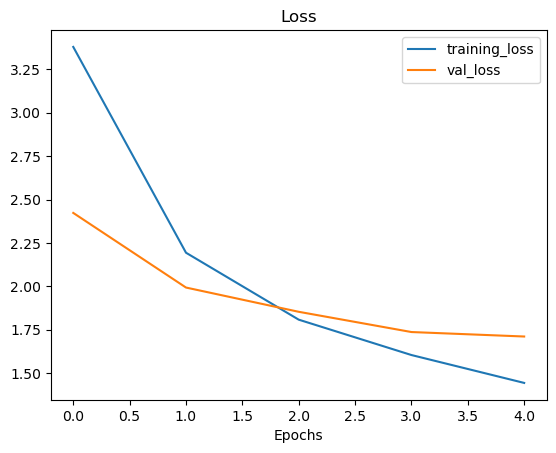

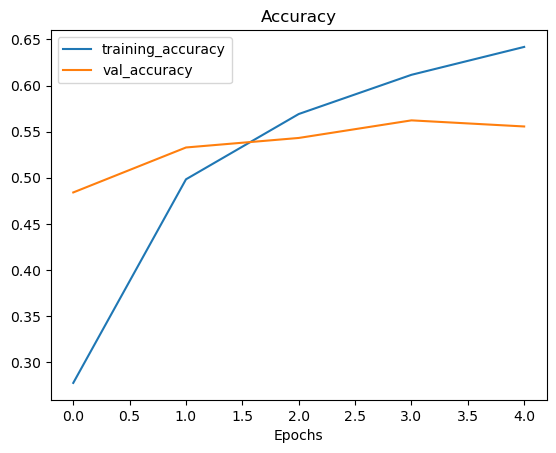

In [17]:
plot_loss_curves(m0History)

- the loss curves indicate there might be som "overfitting"
  - when the loss decreases in the TRAINING data but does not decrease in the VALIDATION data, the model is getting "better" at the training data and not getting better at the validation data

## Model II: Fine-Tuning Model I

### Un-Freeze Layers

In [32]:
base_model.trainable = True

In [33]:
# RE-Freeze all-but-5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

### Re-Compile

In [34]:
m0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [35]:
for idx, layer in enumerate(m0.layers):
    if(layer.trainable == True):
        print(f'layer idx {idx}: {layer.name} is trainable')

layer idx 0: input_layer is trainable
layer idx 1: data_augmentation is trainable
layer idx 2: efficientnetb0 is trainable
layer idx 3: global_average_pooling is trainable
layer idx 4: output_layer is trainable


In [ ]:
for idx, layer in enumerate(base_model.layers):
    if(layer.trainable == True):
        print(f'layer idx {idx}: {layer.name} is trainable')

### Fine-Tune & Fit 

In [40]:
fineTinedEpochCount = 10
m0FineTunedHistory = m0.fit(trainingData10P,
                                                     epochs=fineTinedEpochCount,
                                                     validation_data=testingData10p,
                                                     validation_steps=int(0.15 * len(testingData10p)), # validate on 15% of the test data
                                                     initial_epoch=m0History.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 250s 1s/step - loss: 1.2083 - accuracy: 0.6846 - val_loss: 1.6503 - val_accuracy: 0.5683
Epoch 6/10
237/237 [==============================] - 209s 882ms/step - loss: 1.0835 - accuracy: 0.7114 - val_loss: 1.6716 - val_accuracy: 0.5628
Epoch 7/10
237/237 [==============================] - 206s 870ms/step - loss: 1.0085 - accuracy: 0.7299 - val_loss: 1.6843 - val_accuracy: 0.5540
Epoch 8/10
237/237 [==============================] - 193s 815ms/step - loss: 0.9498 - accuracy: 0.7377 - val_loss: 1.6570 - val_accuracy: 0.5651
Epoch 9/10
237/237 [==============================] - 213s 900ms/step - loss: 0.8768 - accuracy: 0.7649 - val_loss: 1.6934 - val_accuracy: 0.5572
Epoch 10/10
237/237 [==============================] - 216s 912ms/step - loss: 0.8345 - accuracy: 0.7787 - val_loss: 1.7104 - val_accuracy: 0.5546


### Analysis

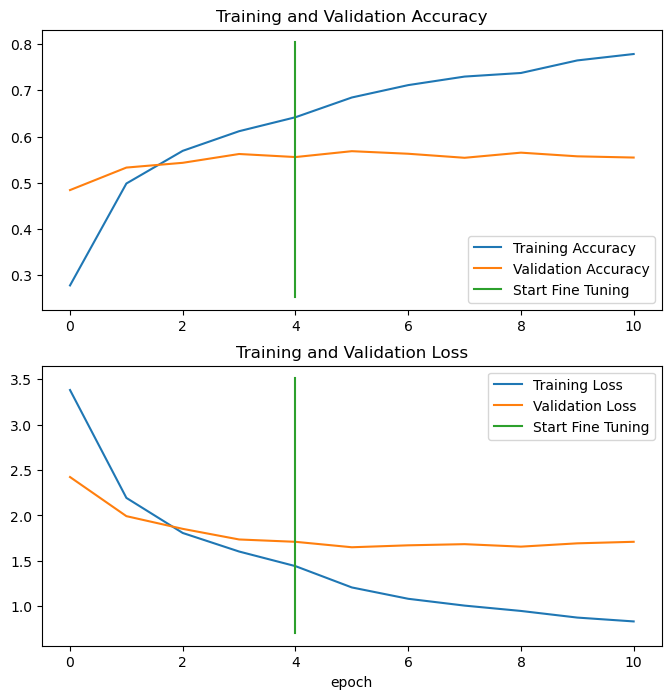

In [41]:
compare_historys(original_history=m0History,
                 new_history=m0FineTunedHistory,
                 initial_epochs=5)

In [46]:
m0Loss, m0Accuracy = m0.evaluate(testingData10p)

790/790 [==============================] - 680s 861ms/step - loss: 1.4948 - accuracy: 0.6040


In [47]:
m0Loss, m0Accuracy

(1.4947682619094849, 0.603960394859314)

## Saving The Model

In [42]:
m0.save('food101-10p-transfer-EfficientNetB0')

INFO:tensorflow:Assets written to: food101-10p-transfer-EfficientNetB0/assets


INFO:tensorflow:Assets written to: food101-10p-transfer-EfficientNetB0/assets


### Load The Model

In [44]:
loadedModel = tf.keras.models.load_model('food101-10p-transfer-EfficientNetB0')

In [45]:
# Check to see if loaded model is a trained model
loaded_loss, loaded_accuracy = loadedModel.evaluate(testingData10p)
loaded_loss, loaded_accuracy

790/790 [==============================] - 859s 1s/step - loss: 1.4948 - accuracy: 0.6040


(1.4947682619094849, 0.603960394859314)

### Make Predictions
Here, pass the testing dataset to the model to make predictions on each testing image

In [48]:
m0PredictionProbabilities = m0.predict(testingData10p, verbose=1)

790/790 [==============================] - 786s 992ms/step


In [49]:
len(m0PredictionProbabilities)

25250

In [51]:
# should be (numberOfImages, numberOfClasses)
m0PredictionProbabilities.shape

(25250, 101)

In [52]:
# We get one prediction probability per class
print(f"Number of prediction probabilities for sample 0: {len(m0PredictionProbabilities[0])}")
print(f"What prediction probability sample 0 looks like:\n {m0PredictionProbabilities[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {m0PredictionProbabilities[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.38797715e-01 1.56522481e-04 1.84852049e-01 2.51532555e-07
 6.30765408e-06 2.08739220e-06 3.40351107e-05 9.20998900e-06
 2.68313698e-02 1.46380131e-04 1.55132750e-06 1.47509627e-05
 3.95400508e-04 5.50755203e-07 1.71097368e-02 1.84540008e-03
 2.63588008e-05 2.13402603e-03 3.35166999e-03 2.35583975e-05
 6.41028280e-04 1.90715873e-05 3.34971584e-04 1.72030297e-04
 8.83393164e-04 3.70974117e-03 6.73105242e-04 1.84026387e-04
 1.11462243e-01 1.73394848e-03 7.70868974e-06 9.65540588e-04
 2.93610385e-04 2.27731130e-06 4.36247699e-03 1.79853862e-06
 1.66264756e-04 1.98309636e-03 1.17606565e-01 1.27134816e-04
 4.67437756e-04 2.41094809e-02 2.62722198e-04 2.31625236e-05
 8.80344087e-05 1.56951319e-05 8.25790281e-04 1.41687458e-04
 4.67074324e-06 4.34673764e-02 1.68295403e-04 1.05964165e-04
 5.41644245e-02 2.79162861e-02 2.64742357e-05 1.02083925e-02
 2.01777387e-02 3.16690025e-03 5.36395330e-

In [54]:
# Get JUST THE CLASS NUMBER (0-100) of each label of each prediction
pred_classes = m0PredictionProbabilities.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([ 2,  0,  0, 38,  8, 78, 29,  0,  2,  0])

### Get Labels From test data

In [55]:
testDataLabels = []
for images, labels in testingData10p.unbatch(): # unbatch the test data and get images and labels
  testDataLabels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
testDataLabels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [56]:
len(testDataLabels)

25250